In [2]:
import MDAnalysis as mda
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
u = mda.Universe('./protein-dry.psf', './protein-dry-2000ns.dcd')

Frame numbers corresponding to each centroid:
Cluster 0: Frame 18830
Cluster 1: Frame 3490
Cluster 2: Frame 10850
Cluster 3: Frame 1220
Cluster 4: Frame 5620


/home/hlu/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/hlu/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/hlu/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  "".format(attrname, default))
/home/hlu/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/hlu/miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))

Cluster densities (from most to least populated):
Cluster 2: 0.4590 (918/2000)
Cluster 0: 0.2210 (442/2000)
Cluster 3: 0.1320 (264/2000)
Cluster 1: 0.1055 (211/2000)
Cluster 4: 0.0825 (165/2000)


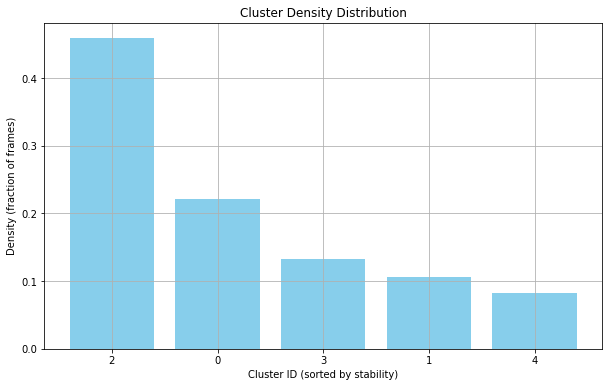

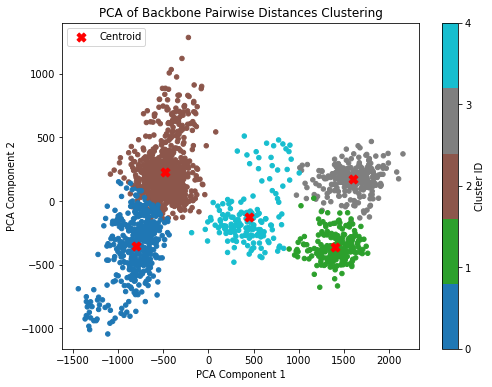

Clustering complete. Backbone centroid structures saved.


In [6]:
# 🔁 Change from CA atoms to full backbone atoms
backbone_atoms = u.select_atoms('protein and backbone')

# Optionally downsample (e.g., every 2nd atom); here we keep all
selected_backbone_indices = np.arange(0, len(backbone_atoms))
selected_backbone_atoms = backbone_atoms[selected_backbone_indices]

flattened_distances = []
frame_indices = []

total_frames = len(u.trajectory)

# Process every 100th frame
for frame_index in range(0, total_frames, 10):
    u.trajectory[frame_index]
    
    positions = selected_backbone_atoms.positions
    dist_matrix = squareform(pdist(positions))
    flattened_distance = dist_matrix[np.triu_indices(len(selected_backbone_atoms), k=1)]
    
    flattened_distances.append(flattened_distance)
    frame_indices.append(frame_index)

flattened_distances = np.array(flattened_distances)

# PCA dimensionality reduction
pca = PCA(n_components=2)
reduced_distances = pca.fit_transform(flattened_distances)

# KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_distances)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Find closest frame to each centroid
centroid_frames = []
for centroid in centroids:
    distances = np.linalg.norm(flattened_distances - centroid, axis=1)
    closest_frame = np.argmin(distances)
    centroid_frames.append(frame_indices[closest_frame])

print("Frame numbers corresponding to each centroid:")
for i, frame in enumerate(centroid_frames):
    print(f"Cluster {i}: Frame {frame}")

# 🔁 Save backbone conformations (instead of CA atoms)
for i, frame in enumerate(centroid_frames):
    u.trajectory[frame]
    selected_backbone_atoms.write(f"backbone_centroid_cluster_{n_clusters}clusters_{i}-5clusters.pdb")

# Cluster density analysis
cluster_counts = np.bincount(labels)
total_frames = len(labels)
cluster_density = cluster_counts / total_frames

sorted_indices = np.argsort(cluster_density)[::-1]
sorted_density = cluster_density[sorted_indices]
sorted_labels = np.arange(n_clusters)[sorted_indices]

print("Cluster densities (from most to least populated):")
for i, (idx, density) in enumerate(zip(sorted_labels, sorted_density)):
    print(f"Cluster {idx}: {density:.4f} ({cluster_counts[idx]}/{total_frames})")

# Plot cluster density distribution
colors = plt.cm.get_cmap('tab10', n_clusters)
cmap = mcolors.ListedColormap(colors(range(n_clusters)))

bounds = np.arange(n_clusters + 1) - 0.5
colorbar_labels = [str(i) for i in range(n_clusters)]

plt.figure(figsize=(10, 6))
plt.bar(range(n_clusters), sorted_density, color='skyblue')
plt.xticks(range(n_clusters), sorted_labels)
plt.xlabel('Cluster ID (sorted by stability)')
plt.ylabel('Density (fraction of frames)')
plt.title('Cluster Density Distribution')
plt.savefig('cluster_density_backbone-5clusters.jpg', dpi=300)
plt.grid(True)
plt.show()

# Plot PCA 2D cluster map
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_distances[:, 0], reduced_distances[:, 1], c=labels, cmap=cmap, s=20)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=80, label='Centroid')
cbar = plt.colorbar(scatter, ticks=np.arange(n_clusters))
cbar.set_label('Cluster ID')
cbar.set_ticklabels(colorbar_labels)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Backbone Pairwise Distances Clustering')
plt.legend(loc='upper left')
plt.savefig('pca_backbone_clustering-5clusters.jpg', dpi=300)
plt.show()

print("Clustering complete. Backbone centroid structures saved.")